# Breakout training with CNN

## Import Libraries

In [1]:
%matplotlib inline
import os                                      # to create folders
import gym                                     # contains the game environment
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from datetime import datetime                  # to print a timestamp
import pickle                                  # to save on file
import torch                                   # ANNs
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# Tracking version for saving weights
version = "03"

In [3]:
# Creates the game environment

#env = gym.make('Breakout-v0').unwrapped
env = gym.make('BreakoutDeterministic-v4').unwrapped
#env = gym.make('BreakoutNoFrameskip-v4').unwrapped

## Set Up Device

We import IPython's display module to aid us in plotting images to the screen later.

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

## Deep Q-Network

In [5]:
class DQN(nn.Module):
    """Initialize a deep Q-learning network
    
    Hints:
    -----
        Original paper for DQN
    https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    """
  
    def __init__(self, img_height, img_width, n_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        def conv2d_size_out(size, kernel_size, stride=1, padding=0):
            return int(size + 2 * padding - kernel_size) // stride  + 1
        
        convw = conv2d_size_out(
                    conv2d_size_out(
                        conv2d_size_out(img_height, kernel_size=8, stride=4
                    ), kernel_size=4, stride=2
                ), kernel_size=3, stride=1)
        convh = conv2d_size_out(
                    conv2d_size_out(
                        conv2d_size_out(img_width, kernel_size=8, stride=4
                    ), kernel_size=4, stride=2
                ), kernel_size=3, stride=1)
        
        linear_input_size = convw * convh * 64  # = 7 * 7 * 64 = 3136
        
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, n_actions)


    def forward(self, x):
        """
        Calculates probability of each action.
        Called with either one element to determine next action, or a batch during optimization.
        NOTE: a single discrete state is collection of 4 frames
        :param x: processed state of shape b x 4 x 84 x 84
        :returns tensor of shape [batch_size, n_actions] (estimated action values)
        """
        x = x.to(device)
        x = F.relu(self.conv1(x))  # b x 32 x 20 x 20
        x = F.relu(self.conv2(x))  # b x 64 x 9 x 9
        x = F.relu(self.conv3(x))  # b x 64 x 7 x 7
        x = x.view(x.size(0), -1)  # b x (7 * 7 * 64) x 1
        x = F.relu(self.fc1(x))    # b x 512
        x = self.fc2(x)            # b x  4
        return x

In [6]:
folder_save = "models"
os.makedirs(folder_save, exist_ok=True)
folder_checkp = "checkpoints_" + version
filename_checkp = os.path.join(folder_save, folder_checkp)
os.makedirs(filename_checkp, exist_ok=True)

filename_durations = "durations.pickle"
filename_rewards   = "rewards.pickle"
filename_losses    = "losses.pickle"

def exchange_weights(net1, net2):
    net1.load_state_dict(net2.state_dict())

def load_weights(net, filename):
    filename = os.path.join(folder_save, filename)
    net.load_state_dict(torch.load(filename))

def save_weights(net, filename: str):
    filename = os.path.join(folder_save, filename + ".pt")
    torch.save(net.state_dict(), filename)
    
def save_checkpoint(net, optimizer, episode, tot_steps_done):
    checkpoint_dict = {
        "parameters"    : net.state_dict(),
        "optimizer"     : optimizer.state_dict(),
        "episode"       : episode,
        "tot_steps_done": tot_steps_done
    }
    filename_checkp = os.path.join(filename_checkp, "checkpoint_" + str(episode) +".pt")
    torch.save(checkpoint_dict, filename)
    
def save_vectors4plots(episode_durations, episode_rewards, losses):
    # save the vectors
    filename_durations = os.path.join(filename_checkp, filename_durations)
    outfile = open(filename_durations, 'wb')
    pickle.dump(episode_durations, outfile)
    outfile.close()
    
    filename_rewards = os.path.join(filename_checkp, filename_rewards)
    outfile = open(filename_rewards, 'wb')
    pickle.dump(episode_rewards, outfile)
    outfile.close()
    
    filename_losses = os.path.join(filename_checkp, filename_losses)
    outfile = open(filename_losses, 'wb')
    pickle.dump(losses, outfile)
    outfile.close()

## Experience class

In [7]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [8]:
e = Experience(2,3,1,4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## StateHolder class

In [9]:
class StateHolder:
    """ Class which stores the state of the game.
    We will use 4 consecutive frames of the game stacked together.
    This is necessary for the agent to understand the speed and acceleration of game objects.
    """
    
    def __init__(self, number_screens = 4):
        self.first_action = True
        self.state = torch.ByteTensor(1, 84, 84).to(device)
        self.number_screens = number_screens
        
    def push(self, screen):
        new_screen = screen.squeeze(0) # If the first dimension (dim=0) of the tensor is 1, remove it
        if self.first_action:
            self.state[0] = new_screen
            for number in range(self.number_screens-1):
                self.state = torch.cat((self.state, new_screen), 0)
            self.first_action = False
        else:
            self.state = torch.cat((self.state, new_screen), 0)[1:] # append the new frame and remove the first one, so that it will always contain 4 screens
    
    def get(self):
        return self.state.unsqueeze(0)

    def reset(self):
        self.first_action = True
        self.state = torch.ByteTensor(1, 84, 84).to(device)

## Replay Memory

In [10]:
class ReplayMemory():
  
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0       # Number of experiences added to the memory

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(Experience(*args))
        else:
            self.memory[self.push_count % self.capacity] = Experience(*args)  # overwrite the first experiences first
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size    # can we sample from memory?

    def __len__(self):
        return len(self.memory)

## Epsilon Greedy Strategy

In [11]:
class EpsilonGreedyStrategy():

    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, agent_current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * agent_current_step * self.decay)

## Reinforcement Learning Agent

In [12]:
class Agent():

    def __init__(self, strategy, num_actions, device):
        self.strategy     = strategy
        self.num_actions  = num_actions # number of actions that can be taken from a given state
        self.device       = device

    def select_action(self, current_step, state, policy_net):
        rate = self.strategy.get_exploration_rate(current_step)

        if rate > random.random() and state is not None:
            action = random.randrange(self.num_actions)
            return torch.tensor([[action]], device=self.device, dtype=torch.long) # explore      
        else:
            with torch.no_grad():  # since it's not training
                return policy_net(state.float()).argmax(dim=1).to(self.device).view(1, 1) # exploit

## Environment Manager

In [13]:
STATE_W = 84
STATE_H = 84

class EnvManager():

    def __init__(self, env, device):
        self.device = device
        self.env = env
        self.env.reset() # to have an initial observation of the env
        self.max_lives = self.env.ale.lives()
        self.current_screen = None
        self.done = False
        self.n_actions = self.env.action_space.n

    def reset(self):
        """ Resets the env to the initial state
        """
        self.env.reset()
        self.current_screen = None

    def close(self):
        """ Closes the env
        """
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def take_action(self, action):        
        _, reward, self.done, info = self.env.step(action.item())
        return torch.tensor([reward], device=self.device), info

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        """ Returns the current state of the env in the form of a procesed image of the screen
        """
        s = self.get_processed_screen()
        self.current_screen = s
        return s

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render(mode='rgb_array')
        screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114]) # transform to gray scale
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        # Strip off top and bottom
        return screen[32:195,:]

    def transform_screen_data(self, screen):       
        # Convert to uint, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((STATE_W, STATE_H)),
            T.ToTensor()
        ])

        return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach().unsqueeze(0) # add a batch dimension (BCHW)

### Example Screens

#### Non-Processed Screen

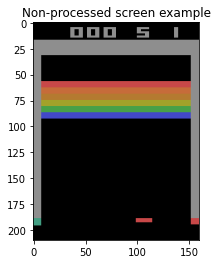

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = EnvManager(env, device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

#### Processed Screen

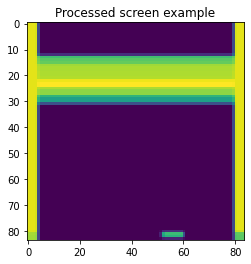

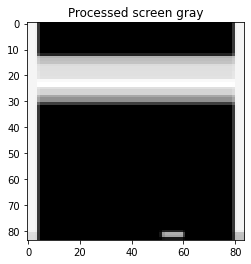

In [15]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Processed screen example')
plt.show()

plt.figure()
plt.imshow(screen.cpu().reshape(-1,84).numpy(),
           interpolation='none', cmap = 'gray')
plt.title('Processed screen gray')
plt.show()

## Utility Functions

### Plotting

In [16]:
folder_figs = "figures"
os.makedirs(folder_figs, exist_ok=True)

def plot_durations(values, moving_avg_period, episode):
    plt.figure(1, figsize=(10,5))
    plt.clf()  # Clear the current figure.
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Duration', fontsize=14)
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    filename = os.path.join(folder_figs, "durations_" + version + ".png")
    plt.savefig(filename)
    print("", moving_avg_period, "episode duration moving avg:", moving_avg[-1])

def plot_rewards(values, moving_avg_period, episode):
    plt.figure(2, figsize=(10,5))
    plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    filename = os.path.join(folder_figs, "rewards_" + version + ".png")
    plt.savefig(filename)
    print("", moving_avg_period, "episode reward moving avg:", moving_avg[-1])

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    else:
        moving_avg = torch.zeros(len(values))
    return moving_avg.numpy()

def plot_loss(values, episode):
    plt.figure(3, figsize=(10,5))
    plt.xlabel('Update', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.plot(values)
    filename = os.path.join(folder_figs, "loss_" + version + ".png")
    plt.savefig(filename)

### Tensor Processing

In [17]:
def extract_tensors(experiences):
    """ Transposes the batch.
    This converts batch-array of Experiences to Experience of batches (batch-arrays)
    """
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state).float().to(device)
    t2 = torch.cat(batch.action)
    t3 = batch.next_state   # I don't want to concatenate all the next_states
    t4 = torch.cat(batch.reward)

    return (t1,t2,t3,t4)

**Exapmple of `Experience(*zip(*experiences))` used above.**

See https://stackoverflow.com/a/19343/3343043 for detailed explanation.

In [18]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [19]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Q-Value Calculator

In [20]:
class QValues():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        """ Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
            These are the actions which would've been taken for each batch state according to policy_net
        """
        return policy_net(states).gather(dim=1, index=actions)

    @staticmethod        
    def get_next(policy_net, target_net, next_states):
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, next_states)),
                                        device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in next_states if s is not None]).float().to(device)
    
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        batch_size = len(next_states) # Since I didn't concatenate the states
        values = torch.zeros(batch_size, device=QValues.device)
        action = policy_net(non_final_next_states).detach().argmax(dim=1).view(-1,1)
        values[non_final_mask] = target_net(non_final_next_states).detach().gather(1, action).view(-1)
        return values

## Main Program

In [21]:
# Hyperparameters
batch_size          = 32
gamma               = 0.99
eps_start           = 1           #
eps_end             = 0.1         # parameters for e-greedy strategy for action selection
eps_decay           = 0.0000001   #
optimize_model_step = 4           # Number of frames after which we train the model 
target_net_update   = 50          # Number of episodes after which we update the target model
memory_size         = 200_000
lr                  = 0.00001
num_episodes        = 15_000
timestep_max        = 18_000      # Number of timesteps after which we end an episode

save_fig_step       = 200

In [22]:
# Essential Objects

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

em           = EnvManager(env, device)
strategy     = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent        = Agent(strategy, em.n_actions, device)
memory       = ReplayMemory(memory_size)
state_holder = StateHolder()

policy_net   = DQN(em.get_screen_height(), em.get_screen_width(), em.n_actions).to(device)
target_net   = DQN(em.get_screen_height(), em.get_screen_width(), em.n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # since we only use this net for inference

optimizer = optim.Adam(params = policy_net.parameters(), lr = lr)

Training on device: cpu


### Training Loop

In [23]:
# datetime object containing current date and time
start = datetime.now()
# format: dd/mm/YY H:M:S
print("Starting date and time: ", start.strftime("%d/%m/%Y %H:%M:%S"))

Starting date and time:  28/07/2021 15:42:12


In [24]:
episode_durations = []
episode_rewards = []
losses = []
tot_steps_done = 0

policy_net.train()

for episode in range(1, num_episodes + 1): # I prefer starting from 1
    em.reset()
    state_holder.push(em.get_state())
    episode_reward = 0
    lives = em.max_lives

    for timestep in count():
        # Transition handling code
        state  = state_holder.get()
        action = agent.select_action(tot_steps_done,state, policy_net)
        reward, info = em.take_action(action)
        episode_reward += reward
        life = info['ale.lives'] # or em.env.ale.lives()
        
        state_holder.push(em.get_state())
        next_state = state_holder.get()
        
        # Trick to significantly improve the convergence of training: if the episode did not end but the
        # agent lost a life, then such a transition should be put in ReplayMemory as the final one.
        # In this case, it is necessary to continue the episode until done == True
        # At the same time, you will teach the agent that losing lives is bad.
        
        if not em.done:
            if life < lives:
                next_state, lives = (None, life)
        else:
            next_state = None
            reward = torch.zeros_like(reward) # It has to be a Tensor!
        memory.push(state.to('cpu'), action, next_state, reward)
        state = next_state
        
        tot_steps_done += 1
        
        # Optimization step
        if memory.can_provide_sample(batch_size) and tot_steps_done % optimize_model_step == 0:
            experiences = memory.sample(batch_size)
            
            states, actions, next_states, rewards = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(policy_net, target_net, next_states)
            # Compute the expected Q values using the Bellman's equation
            target_q_values = rewards + (gamma * next_q_values)
            
            # Compute Huber loss
            loss = F.smooth_l1_loss(current_q_values, target_q_values.unsqueeze(1))
            # loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            losses.append(loss)
            
            # Optimizing the model
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
            
            # Trying to save memory
            del experiences
            del states
            del actions
            del next_states
            del rewards
            del current_q_values
            del next_q_values
            del target_q_values
            del loss
        
        if em.done:
            episode_durations.append(timestep)
            episode_rewards.append(episode_reward)
            print("Episode", episode)
            print("Total steps done", tot_steps_done)
            if is_ipython: display.clear_output(wait=True)
            break
            
        if timestep > timestep_max:
            break
    
    if episode % save_fig_step == 0:
        plot_durations(episode_durations, 100, episode)
        plot_rewards(episode_rewards, 100, episode)
        plot_loss(losses, episode)

    if episode % target_net_update == 0:
        exchange_weights(target_net, policy_net)
        save_checkpoint(policy_net, optimizer, episode, tot_steps_done)
        save_vectors4plots(episode_durations, episode_rewards, losses)

save_weights(policy_net, "CNN_" + version)
em.close()

UnboundLocalError: local variable 'filename_checkp' referenced before assignment

In [ ]:
end = datetime.now()
# format: dd/mm/YY H:M:S
print(f"Finishing date and time: ", end.strftime("%d/%m/%Y %H:%M:%S"))
print(f"Total time training: {end-start}")

Let's play an episode to see if it learned to play:

In [ ]:
#policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.n_actions).to(device)
#load_weights(policy_net, "CNN_" + version + ".pt")
policy_net.eval()

for episode in range(1):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        state = em.get_state()
        if em.done:
            break
        
em.close()